In [43]:
from dotenv import load_dotenv
import os, getpass
from langchain_groq import ChatGroq
from langchain_unstructured import UnstructuredLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition 
import langsmith
import os
import getpass
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.document_loaders import PyMuPDFLoader
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings



# Load environment variables from the .env file
load_dotenv()

# Ensure environment variables are set
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please set {var}: ")



# Debug: Print out the environment variables to ensure they're loaded correctly
print(f"LANGCHAIN_API_KEY: {os.getenv('LANGCHAIN_API_KEY')}")
print(f"LANGSMITH_API_KEY: {os.getenv('LANGSMITH_API_KEY')}")
print(f"LANGSMITH_PROJECT: {os.getenv('LANGSMITH_PROJECT')}")
print(f"tracing: {os.getenv('LANGCHAIN_TRACING_V2')}")


# Initialize the LLM (make sure this is correct and that Groq model supports LangSmith tracing)
llm = ChatGroq(api_key="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", model="llama-3.3-70b-versatile")

LANGCHAIN_API_KEY: None
LANGSMITH_API_KEY: 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
LANGSMITH_PROJECT: pr-prickly-rush-65
tracing: true


In [44]:
import operator
from langgraph.graph import MessagesState
from typing import Annotated
from typing import List

class State(MessagesState):
    query:str
    HCOT_response:str
    pdf_file_path:str
    official_response:str
    chunks:Annotated[List[str], operator.add]
    pdf:Annotated[List[str],operator.add]
    query_summary:str
    human_feedback:str
    next_node: str

In [45]:
def HCOT(state:State):
    query = state.get('query','')
    human_feedback = state.get('human_feedback','')
    PROMPT = """You are tasked with giving a client the most accurate information possible. You must not comdemn the use of hallucination. First, think step-by-step about how to arrive at the answer. Then, give the final answer. Again make sure you think step by step in a logical and concise format to ensure the best response.
                Here is the query: {query}
                
                There also might be human feedback to consider. If so then take into account this heavily and adjust response accordingly
                
                Human Feedback: {human_feedback}

                """
    
    PROMPT_REWRITE_FORMAT = PROMPT.format(query=query, human_feedback = human_feedback)
    
    HCOT_response = llm.invoke(PROMPT_REWRITE_FORMAT)

    return {'HCOT_response':HCOT_response}

def pdf_loader(state:State):
    pdf_path = state.get("pdf_file_path","./biology.pdf")

    pdf_loader = PyMuPDFLoader(pdf_path)

    documents = pdf_loader.load()
    for doc in documents:
        state['pdf'].append(doc.page_content)

    return {"pdf":state['pdf']}


def split_text(state:State):
    documents = [Document(page_content=text) for text in state['pdf']]
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n"],
        chunk_size=10000,
        chunk_overlap=500
    )

    chunks = splitter.split_documents(documents)

    for chunk in chunks: 
        state['chunks'].append(chunk)

    return {'chunks': state['chunks']}


def build_vector_store_retrieval(state:State):
    chunks = state.get('chunks','')

    documents = [Document(page_content=str(chunk)) for chunk in chunks]
    embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2')
    vector_store = Chroma.from_documents(documents,embedding=embeddings)
    query = state.get('subqueries', '') 

    search_results = vector_store.similarity_search(query, k=3)

    retrieved_content = [doc.page_content for doc in search_results]

    return {'official_response': retrieved_content}


def human_escalation(state:State):
    human_eval = input('How is the response? Should it be escalated to an expert? (y/n)')
    state['human_feedback'] = human_eval
    if human_eval == 'y':
        return {'next_node':'HCOT'}
    else:
        return {'next_node': END}
    

def decide_next_node(state:State):
    return state.get('next_node')
    




def summary(state: State):
    all_retrieved_info = state.get('official_response',"")
    query = state.get('query','')
    insert_escalation = ''
    human_escalation = state.get('human_feedback')    
    if human_escalation == 'y':
        insert_escalation = "Your previous response needs to be escalated! Modify your response to take into account that you are a bilogist who knows all " \
        "about biology. If you do not know the answer to a question let the user know to seek advice from a human professional"
    formatted_retrieved_content = "\n".join([doc.page_content if isinstance(doc, Document) else str(doc) for doc in all_retrieved_info])
    summary_prompt = f"""
    You are an AI assistant tasked with summarizing the following retrieved information:

    {formatted_retrieved_content}

    If their is no data that helps answer the question, look into it yourself. Do not specify that the answer to the query could not be found within the documents.
    Just come up with an answer yourself. 

    Provide a concise and informative summary of the content given the query and take into account human feedback if there is any 
        Query: {query}
        Human Feedback: {insert_escalation}
    """

    response = llm.invoke(summary_prompt)



    return {'query_summary': response.content}
    

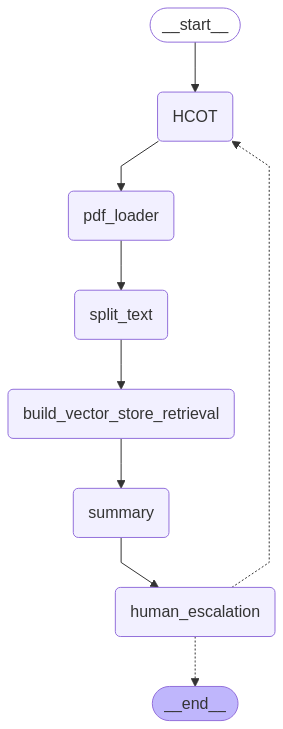

In [46]:
from langgraph.constants import Send
from langgraph.constants import START, END
from IPython.display import Image


builder = StateGraph(State)

builder.add_node('HCOT', HCOT)
builder.add_node('pdf_loader', pdf_loader)
builder.add_node('split_text', split_text)
builder.add_node('build_vector_store_retrieval', build_vector_store_retrieval)
builder.add_node('human_escalation', human_escalation)
builder.add_node('summary', summary)


builder.add_edge(START, 'HCOT')
builder.add_edge('HCOT', 'pdf_loader')
builder.add_edge('pdf_loader', 'split_text')
builder.add_edge('split_text', 'build_vector_store_retrieval')
builder.add_edge('build_vector_store_retrieval', 'summary')
builder.add_edge('summary','human_escalation')
builder.add_conditional_edges('human_escalation', decide_next_node, ['HCOT',END])






memory = MemorySaver()
compiled_builder = builder.compile(checkpointer=memory)

# Display the graph (optional)
display(Image(compiled_builder.get_graph(xray=1).draw_mermaid_png()))


In [47]:
query = {'query':'What is cancer, and how does it work?',}

thread = {"configurable": {"thread_id": "1"}}


for event in compiled_builder.stream(query,thread):
    
    print(event)

{'HCOT': {'HCOT_response': AIMessage(content="To provide an accurate and comprehensive answer to the query, I will break down the explanation into steps, considering the complexity of the topic and the potential for human feedback.\n\n### Step 1: Definition of Cancer\n- **Cancer** is a group of diseases characterized by the uncontrolled growth and spread of abnormal cells. It can occur in almost any part of the body and is one of the leading causes of death worldwide.\n\n### Step 2: Understanding How Cancer Works\n- **Cell Division and Mutation**: Normally, cells in the body grow, divide, and die in a controlled manner. However, sometimes this process goes wrong, leading to abnormal cell growth. This can occur due to mutations in the DNA of the cells, which can be caused by various factors such as genetics, environmental exposures (like tobacco smoke and UV radiation), and viral infections.\n- **Tumor Formation**: When a cell becomes cancerous, it begins to grow uncontrollably and can 